In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm

datadir = "/home/ephy/Projects/tda_convolve_video/data/"

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'

from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

In [2]:
allVids = pd.read_csv(datadir + 'altered/all_data_guide_FFR.csv')
allVids = allVids.sort_values(by=['clip', 'frame'])
allVids_dedup = allVids.drop_duplicates(subset=['clip'], keep='first').copy()

In [3]:
# Make an interger based class to make tracking tests more simple
classXwalk = pd.DataFrame({'class': np.unique(allVids_dedup['class'])})
classXwalk['ind'] = np.array(list(range(0,101)))
allVids_dedup['class_int'] = [int(classXwalk['ind'][classXwalk['class']==c]) for c in allVids_dedup['class']]

In [4]:
all_image = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/allVidStack100x100_FFR_13frames.npy', allow_pickle=True)
all_image = all_image[:,0:9,...]

In [5]:
filters0 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3//KleinFeatures_55.npy', allow_pickle=True)
filters0 = filters0.reshape(64,1,1,7,7)
filters = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355_movandrot.npy', allow_pickle=True)
filters77 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_377_movAndRot180.npy', allow_pickle=True)

In [6]:
def test(net, X, y, batchSize):
    confusionMatrix = np.zeros([101,101], dtype=np.int8)
    testingSeq = list(range(0,y.shape[0]+1,batchSize))
    testingSeq.append(y.shape[0]+1)
    testingSeq = np.array(testingSeq)
    with torch.no_grad():
        for i in range(len(testingSeq)-1):
            data = X[testingSeq[i]:testingSeq[i+1]].view(-1,1,9,100,100).to(device)
            out = torch.argmax(net(data),axis=1).cpu()
            yt = torch.argmax(y[testingSeq[i]:testingSeq[i+1]],axis=1)
            for pred,label in zip(out,yt):
                confusionMatrix[label][pred] +=1
    del data
    del out
    del yt
    return confusionMatrix

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv3d(1, 64, (1,7,7),stride=(1,2,2))
        
        self.conv1 = nn.Conv3d(64, 180, (3,5,5))
        self.conv2 = nn.Conv3d(180, 180, (3,5,5))
        self.conv3 = nn.Conv3d(180, 180, (3,3,3))
        self.conv4 = nn.Conv3d(180, 36, (1,3,3))
        
        x= torch.randn(1,1,9,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 400)
        self.fc3 = nn.Linear(400, 101)
        
        self.batch1 = nn.BatchNorm1d(self._to_linear)
        self.batch2 = nn.BatchNorm1d(1000)
        self.batch3 = nn.BatchNorm1d(400)
#         self.drop1 = nn.Dropout(p=0.2)
        self.drop2 = nn.Dropout(p=0.2)
        
        
    def convs(self, x):
        x = F.max_pool3d(F.relu(self.conv0(x)),(1,3,3),stride=(1,2,2))
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
#         x = self.drop1(x)
        x = x.view(-1, self._to_linear)
#         x = self.batch1(x)
        x = F.leaky_relu(self.fc1(x))
#         x = self.batch2(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.batch3(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [8]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

0.071360512

In [9]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=64
trainingBatchSize=64
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

foldIndex=0

# net = Net().to(device)
# optimizer = optim.Adam(net.parameters(), lr=1e-5)


# Set filters in 2 layers
with torch.no_grad():
    for i,weights in enumerate(filters0):
        net.conv0.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.conv0.requires_grad=False

print('Network Reset.')

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         print(net.conv0.weight.shape)
#         plt.imshow(net.conv0.weight[i][0][0].cpu(), cmap='gray')
#         plt.show
#         break        
                



X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                    shuffle=True, random_state=foldIndex,
                                                    test_size=0.33, stratify = allVids_dedup['class_int'])


y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
trainingSeq.append(y_train.shape[0]+1)
trainingSeq = np.array(trainingSeq)

# Grab 5 tests in final epoch (4 + last one run after training loop)
finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

for epoch in range(EPOCHS):
    for i in range(len(trainingSeq)-1):
        X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
        X=X.to(device)
        y=y_train[trainingSeq[i]:trainingSeq[i+1]]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec[foldIndex].append(float(loss.tolist()))
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if epoch==(EPOCHS-1) and (i in finalEpochTests):
            print(foldIndex,'Final Epoch',i)
            results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    print('Fold: ', foldIndex, 'Epoch: ',epoch)
    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    cm = results[foldIndex][len(results[foldIndex])-1]
    print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))
    

Network Reset.
Fold:  0 Epoch:  0
Accuracy:  0.06301182893539581
Fold:  0 Epoch:  1
Accuracy:  0.08848953594176524


KeyboardInterrupt: 

In [ ]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

In [ ]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=64
trainingBatchSize=64
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

foldIndex=0

# net = Net().to(device)
# optimizer = optim.Adam(net.parameters(), lr=1e-5)


# Set filters in 2 layers
with torch.no_grad():
    for i,weights in enumerate(filters0):
        net.conv0.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.conv0.requires_grad=False
    for i,weights in enumerate(flat_filters):
        net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.conv1.requires_grad=False

print('Network Reset.')

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         plt.imshow(net.conv1.weight[i,63,2].cpu(), cmap='gray')
#         plt.show()
#         break        
                



X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                    shuffle=True, random_state=foldIndex,
                                                    test_size=0.33, stratify = allVids_dedup['class_int'])


y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
trainingSeq.append(y_train.shape[0]+1)
trainingSeq = np.array(trainingSeq)

# Grab 5 tests in final epoch (4 + last one run after training loop)
finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

for epoch in range(EPOCHS):
    for i in range(len(trainingSeq)-1):
        X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
        X=X.to(device)
        y=y_train[trainingSeq[i]:trainingSeq[i+1]]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec[foldIndex].append(float(loss.tolist()))
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if epoch==(EPOCHS-1) and (i in finalEpochTests):
            print(foldIndex,'Final Epoch',i)
            results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    print('Fold: ', foldIndex, 'Epoch: ',epoch)
    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    cm = results[foldIndex][len(results[foldIndex])-1]
    print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))
    

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv3d(1, 320, (3,7,7),stride=(1,2,2),bias=False)
        self.conv2 = nn.Conv3d(320, 180, (3,5,5))
        self.conv3 = nn.Conv3d(180, 180, (3,3,3))
        self.conv4 = nn.Conv3d(180, 180, (1,3,3))
        self.conv5 = nn.Conv3d(180, 180, (1,3,3))
        self.conv6 = nn.Conv3d(180, 180, (1,3,3))
        self.conv7 = nn.Conv3d(180, 180, (1,3,3))
        
        x= torch.randn(1,1,9,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 400)
        self.fc3 = nn.Linear(400, 101)
        
        self.batch1 = nn.BatchNorm1d(self._to_linear)
        self.batch2 = nn.BatchNorm1d(1000)
        self.batch3 = nn.BatchNorm1d(400)
#         self.drop1 = nn.Dropout(p=0.2)
        self.drop2 = nn.Dropout(p=0.2)
        
        
    def convs(self, x):
        x = F.max_pool3d(F.relu(self.conv1(x)),(1,3,3),stride=(1,2,2))        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
#         x = self.drop1(x)
        x = x.view(-1, self._to_linear)
#         x = self.batch1(x)
        x = F.leaky_relu(self.fc1(x))
#         x = self.batch2(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.batch3(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [ ]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

In [ ]:
# Try this out with bathcnorms
# Try this out with higher resolution and proper aspect ratio

In [ ]:
EPOCHS = 100
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=60
trainingBatchSize=60
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

foldIndex=0

# net = Net().to(device)
# optimizer = optim.Adam(net.parameters(), lr=1e-5)


# Set filters in 2 layers
with torch.no_grad():
    for i,weights in enumerate(filters77):
        net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.conv1.requires_grad=False

print('Network Reset.')

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
#         plt.show()
#         break        
                



X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                    shuffle=True, random_state=foldIndex,
                                                    test_size=0.33, stratify = allVids_dedup['class_int'])


y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
trainingSeq.append(y_train.shape[0]+1)
trainingSeq = np.array(trainingSeq)

# Grab 5 tests in final epoch (4 + last one run after training loop)
finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

for epoch in range(EPOCHS):
    for i in range(len(trainingSeq)-1):
        X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
        X=X.to(device)
        y=y_train[trainingSeq[i]:trainingSeq[i+1]]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec[foldIndex].append(float(loss.tolist()))
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if epoch==(EPOCHS-1) and (i in finalEpochTests):
            print(foldIndex,'Final Epoch',i)
            results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    print('Fold: ', foldIndex, 'Epoch: ',epoch)
    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    cm = results[foldIndex][len(results[foldIndex])-1]
    print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))
    

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 180, (3,7,7))
        
        
        self.conv1 = nn.Conv3d(180, 180, (3,5,5))
        self.conv2 = nn.Conv3d(180, 180, (3,5,5))
        self.conv3 = nn.Conv3d(180, 180, (3,5,5))
        self.conv4 = nn.Conv3d(180, 180, (3,5,5))
        self.conv5 = nn.Conv3d(180, 180, (3,5,5))
        self.conv6 = nn.Conv3d(180, 180, (3,5,5))
        self.conv7 = nn.Conv3d(180, 75, (3,5,5))
        
        self.batchConv1 = nn.BatchNorm3d(180)
        self.batchConv2 = nn.BatchNorm3d(180)
        self.batchConv3 = nn.BatchNorm3d(180)
        self.batchConv4 = nn.BatchNorm3d(180)
        self.batchConv5 = nn.BatchNorm3d(75)
        
        self.up = nn.Upsample((7,31,31),mode='trilinear',align_corners=False)
        
        x= torch.randn(1,1,9,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 700)
        self.fc2 = nn.Linear(700, 200)
        self.fc3 = nn.Linear(200, 101)        
        
        self.batch1 = nn.BatchNorm1d(self._to_linear)
        self.batch2 = nn.BatchNorm1d(750)
        self.batch3 = nn.BatchNorm1d(200)
        self.drop2 = nn.Dropout(p=0.2)
        
        
    def convs(self, x):
        x = F.max_pool3d(self.convRescale(x),(1,3,3))
        x = self.batchConv1(x)
        inp1 = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchConv2(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchConv3(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.batchConv4(x)
        x = self.up(x)
        x+=inp1
        del inp1
        x = F.relu(self.conv7(x))
        x = self.batchConv5(x)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.batch3(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [ ]:
net = ResNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

In [ ]:
filters77 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_377_movAndRot180.npy', allow_pickle=True)
filters77.shape

In [ ]:
EPOCHS = 100
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=30
trainingBatchSize=30
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

foldIndex=0

# net = Net().to(device)
# optimizer = optim.Adam(net.parameters(), lr=1e-5)


# Set filters in 2 layers
with torch.no_grad():
    for i,weights in enumerate(filters77):
        net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.conv1.requires_grad=False

print('Network Reset.')

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
#         plt.show()
#         break        
                



X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                    shuffle=True, random_state=foldIndex,
                                                    test_size=0.33, stratify = allVids_dedup['class_int'])


y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
trainingSeq.append(y_train.shape[0]+1)
trainingSeq = np.array(trainingSeq)

# Grab 5 tests in final epoch (4 + last one run after training loop)
finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

for epoch in range(EPOCHS):
    for i in range(len(trainingSeq)-1):
        X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
        X=X.to(device)
        y=y_train[trainingSeq[i]:trainingSeq[i+1]]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec[foldIndex].append(float(loss.tolist()))
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if epoch==(EPOCHS-1) and (i in finalEpochTests):
            print(foldIndex,'Final Epoch',i)
            results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    print('Fold: ', foldIndex, 'Epoch: ',epoch)
    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    cm = results[foldIndex][len(results[foldIndex])-1]
    print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))
    

In [ ]:
EPOCHS = 100
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=30
trainingBatchSize=30
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

foldIndex=0

# net = ResNet().to(device)
# optimizer = optim.Adam(net.parameters(), lr=1e-5)


# Set filters in 2 layers
with torch.no_grad():
    for i,weights in enumerate(filters77):
        net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
    net.convRescale.requires_grad=False

print('Network Reset.')

# ## Check our work
# with torch.no_grad():
#     for i,weights in enumerate(flat_filters):
#         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
#         plt.show()
#         break        
                



X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                    shuffle=True, random_state=foldIndex,
                                                    test_size=0.33, stratify = allVids_dedup['class_int'])


y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test =  torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
trainingSeq.append(y_train.shape[0]+1)
trainingSeq = np.array(trainingSeq)

# Grab 5 tests in final epoch (4 + last one run after training loop)
finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

for epoch in range(EPOCHS):
    for i in range(len(trainingSeq)-1):
        X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
        X=X.to(device)
        y=y_train[trainingSeq[i]:trainingSeq[i+1]]
        y=y.to(device)
        net.zero_grad()
        output = net(X)
        loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
        lossrec[foldIndex].append(float(loss.tolist()))
        loss.backward()
        optimizer.step()
        del loss
        del output
        del X
        del y
        if epoch==(EPOCHS-1) and (i in finalEpochTests):
            print(foldIndex,'Final Epoch',i)
            results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    print('Fold: ', foldIndex, 'Epoch: ',epoch)
    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
    cm = results[foldIndex][len(results[foldIndex])-1]
    print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))
    

In [ ]:
EPOCHS = 30
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=30
trainingBatchSize=30
results = [[],[],[]]
lossrec = [[],[],[]]

classMat = np.eye(101,dtype=np.float)

for foldIndex in range(3):

    net = ResNet().to(device)
    optimizer = optim.Adam(net.parameters(), lr=5e-6)

    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters77):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        net.convRescale.requires_grad=False

    print('Network Reset.')

    # ## Check our work
    # with torch.no_grad():
    #     for i,weights in enumerate(flat_filters):
    #         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
    #         plt.show()
    #         break        


    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
#             if epoch==(EPOCHS-1) and (i in finalEpochTests):
#                 print(foldIndex,'Final Epoch',i)
#                 results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_k1layer_30_res.npy', results)
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_k1layer_30_loss.npy', lossrec)

In [ ]:
normRes = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_res.npy', allow_pickle=True)
normLoss = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_loss.npy', allow_pickle=True)

a = np.array([[np.sum(np.diag(cm))/np.sum(cm) for cm in result] for result in normRes])

plt.plot(np.mean(a,axis=0))
plt.plot(np.mean(a,axis=0)-np.std(a, axis=0),color='gray', linestyle='--')
plt.plot(np.mean(a,axis=0)+np.std(a, axis=0),color='gray', linestyle='--')

In [ ]:
EPOCHS = 30
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=30
trainingBatchSize=30
# results = [[],[],[]]
# lossrec = [[],[],[]]

# SWITCHED ON FIRST LAYER AT 27 E

classMat = np.eye(101,dtype=np.float)

for foldIndex in range(3):

    net = ResNet().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

#     #Set filters in 2 layers
#     with torch.no_grad():
#         for i,weights in enumerate(filters77):
#             net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#         net.convRescale.requires_grad=False

    print('Network Reset.')

    # ## Check our work
    # with torch.no_grad():
    #     for i,weights in enumerate(flat_filters):
    #         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
    #         plt.show()
    #         break        


    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
#             if epoch==(EPOCHS-1) and (i in finalEpochTests):
#                 print(foldIndex,'Final Epoch',i)
#                 results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_res_30.npy', results)
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_loss_30.npy', lossrec)

In [ ]:
normRes = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_res.npy', allow_pickle=True)
normLoss = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_loss.npy', allow_pickle=True)

a = np.array([[np.sum(np.diag(cm))/np.sum(cm) for cm in result] for result in normRes])

k1Res = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_l1klein_res.npy', allow_pickle=True)
k1Loss = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_l1klein_res.npy', allow_pickle=True)

b = np.array([[np.sum(np.diag(cm))/np.sum(cm) for cm in result] for result in k1Res])

plt.plot(np.mean(b,axis=0), label='Trans/Rotate Klein 1st Layer')
plt.plot(np.mean(b,axis=0)-2*np.std(b, axis=0),color='gray', linestyle='--')
plt.plot(np.mean(b,axis=0)+2*np.std(b, axis=0),color='gray', linestyle='--')

plt.plot(np.mean(a,axis=0), label='Normal')
plt.plot(np.mean(a,axis=0)-2*np.std(a, axis=0),color='gray', linestyle='--')
plt.plot(np.mean(a,axis=0)+2*np.std(a, axis=0),color='gray', linestyle='--')

plt.legend()
plt.title('Tangent Klein 1st Layer vs Randomly Instantiated 8-layer ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()


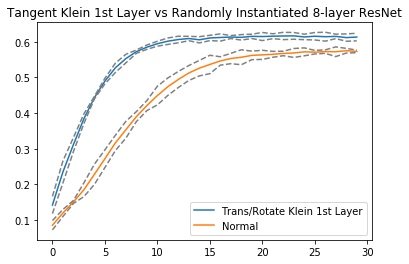

In [2]:
normRes30 = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_normal_res_30.npy', allow_pickle=True)

normRes30[0] = normRes30[0][29:]

a = np.array([[np.sum(np.diag(cm))/np.sum(cm) for cm in result] for result in normRes30])

k1Res = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/resnet8_k1layer_30_res.npy', allow_pickle=True)

b = np.array([[np.sum(np.diag(cm))/np.sum(cm) for cm in result] for result in k1Res])

plt.plot(np.mean(b,axis=0), label='Trans/Rotate Klein 1st Layer')
plt.plot(np.mean(b,axis=0)-2*np.std(b, axis=0),color='gray', linestyle='--')
plt.plot(np.mean(b,axis=0)+2*np.std(b, axis=0),color='gray', linestyle='--')

plt.plot(np.mean(a,axis=0), label='Normal')
plt.plot(np.mean(a,axis=0)-2*np.std(a, axis=0),color='gray', linestyle='--')
plt.plot(np.mean(a,axis=0)+2*np.std(a, axis=0),color='gray', linestyle='--')

plt.legend()
plt.title('Tangent Klein 1st Layer vs Randomly Instantiated 8-layer ResNet')

plt.show()

In [ ]:
class BigResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 180, (3,7,7))
        
        
        self.conv1 = nn.Conv3d(180, 180, (3,5,5))
        self.conv2 = nn.Conv3d(180, 180, (3,5,5))
        self.conv3 = nn.Conv3d(180, 180, (3,5,5))
        self.conv4 = nn.Conv3d(180, 180, (3,5,5))
        self.conv5 = nn.Conv3d(180, 180, (3,5,5))
        self.conv6 = nn.Conv3d(180, 180, (3,5,5))
        self.conv7 = nn.Conv3d(180, 180, (3,5,5))
        self.conv8 = nn.Conv3d(180, 180, (3,5,5))
        self.conv9 = nn.Conv3d(180, 180, (3,5,5))
        self.conv10 = nn.Conv3d(180, 180, (3,5,5))
        self.conv11 = nn.Conv3d(180, 180, (3,5,5))
        self.conv12 = nn.Conv3d(180, 180, (3,5,5))
        self.conv13 = nn.Conv3d(180, 180, (3,5,5))
        self.conv14 = nn.Conv3d(180, 180, (3,5,5))
        self.conv15 = nn.Conv3d(180, 75, (3,5,5))

        
        self.batchConv1 = nn.BatchNorm3d(180)
        self.batchConv2 = nn.BatchNorm3d(180)
        self.batchConv3 = nn.BatchNorm3d(180)
        self.batchConv4 = nn.BatchNorm3d(180)
        self.batchConv5 = nn.BatchNorm3d(180)
        self.batchConv6 = nn.BatchNorm3d(180)
        self.batchConv7 = nn.BatchNorm3d(180)
        self.batchConv8 = nn.BatchNorm3d(75)
        
        self.up = nn.Upsample((7,31,31),mode='trilinear',align_corners=False)
        
        x= torch.randn(1,1,9,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 700)
        self.fc2 = nn.Linear(700, 200)
        self.fc3 = nn.Linear(200, 101)        
        
        self.batch1 = nn.BatchNorm1d(self._to_linear)
        self.batch2 = nn.BatchNorm1d(750)
        self.batch3 = nn.BatchNorm1d(200)
        self.drop2 = nn.Dropout(p=0.2)
        
        
    def convs(self, x):
        x = F.max_pool3d(self.convRescale(x),(1,3,3))
        inp1 = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchConv1(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchConv2(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.batchConv3(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.batchConv4(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.batchConv5(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.batchConv6(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        x = self.batchConv7(x)
        x = self.up(x)
        x+=inp1
        del inp1  
        x = F.relu(self.conv15(x))
        x = self.batchConv8(x)
                
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.batch3(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [ ]:
net = BigResNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

In [ ]:
filters55 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355_movandrot.npy', allow_pickle=True)

In [ ]:
# Testing with small-ish net with klein features in first layer of first block as well

In [ ]:
EPOCHS = 30
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=30
trainingBatchSize=30
results = [[],[],[]]
lossrec = [[],[],[]]

# SWITCHED ON FIRST LAYER AT 27 E

classMat = np.eye(101,dtype=np.float)

for foldIndex in range(3):

    net = ResNet().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

#     #Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters77):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        net.convRescale.requires_grad=False
        for i,weights in enumerate(filters55):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(filters55)).to(device)
        net.conv1.requires_grad=False        

    print('Network Reset.')

    # ## Check our work
    # with torch.no_grad():
    #     for i,weights in enumerate(flat_filters):
    #         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
    #         plt.show()
    #         break        


    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
#             if epoch==(EPOCHS-1) and (i in finalEpochTests):
#                 print(foldIndex,'Final Epoch',i)
#                 results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet16_k1layer_res_30.npy', results)
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet16_k1layer_loss_30.npy', lossrec)

In [ ]:
EPOCHS = 30
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=30
trainingBatchSize=30
results = [[],[],[]]
lossrec = [[],[],[]]

# SWITCHED ON FIRST LAYER AT 27 E

classMat = np.eye(101,dtype=np.float)

for foldIndex in range(3):

    net = ResNet().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

#     #Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters77):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        net.convRescale.requires_grad=False
#         for i,weights in enumerate(filters55):
#             net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(filters55)).to(device)
#         net.conv1.requires_grad=False        

    print('Network Reset.')

    # ## Check our work
    # with torch.no_grad():
    #     for i,weights in enumerate(flat_filters):
    #         plt.imshow(net.conv1.weight[2,0,2].cpu(), cmap='gray')
    #         plt.show()
    #         break        


    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,9,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
#             if epoch==(EPOCHS-1) and (i in finalEpochTests):
#                 print(foldIndex,'Final Epoch',i)
#                 results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet16_k1layer_res_30.npy', results)
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/resnet16_k1layer_loss_30.npy', lossrec)